In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
import time

import re
import os
import os.path
import glob
from PIL import Image
from skimage import io

from sklearn.model_selection import StratifiedKFold                              
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from keras.utils import np_utils

from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from vis.utils import utils
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from vis.visualization import visualize_cam,visualize_saliency,overlay
from keras import activations

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [5]:
# Creating base model (VGG16 convolutional layers)
image_shape = (224, 224, 3)                                                                                                                                               
weights='weights-portex_nolegend-xception-Adam-100epochs-fromscratch.h5'
model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.load_weights(weights)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [7]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# https://github.com/raghakot/keras-vis/issues/53
# "You need to specify penultimate_layer_idx in this case.
# By default, it will use the AveragePooling layer which does not have any spatial resolution.
# Try using the layer above it which has a (7, 7) resolution."
penultimate_layer_idx = utils.find_layer_idx(model, 'block14_sepconv2_act')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Family: allaple
Image: ['2ae9836c12709f8a322a0483d0d696cd50a643dc5b1a72135fcc6fb048eb9142.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 34.99
Image: ['8d1d89e458b4a306eb68eb1ac8998f9e444b91025987c90fa164c0bcfa71029e.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 30.72
Image: ['d10eb7ffb002bd9729f63a668969ac0e674a50d89b5e90397f2e07ebf4246c6d.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 26.90
Image: ['ce623535f3e3ce5e044012141329d6783b2ab027d16e43ceb7446428d26285b9.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 26.47
Image: ['1e495afb2452a3d54cdf657993b38be546f29dd1e2e4cd24c83b9c9d47ff2a74.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 26.33
Image: ['95257620f6d44d0e836c12d077d0aee5642f34b4490e663b1d86086df74d3b0e.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 26.45
Image: ['123efdd242fd08b0691e20781b6254b4ebb42cb53fcac92f0b6c4900142f7318.png'] - Class: ['allaple'] - Pred: 0 (allaple) - Prob: 28.74
Image: ['5eb057c4b11062555e056c19a7b366

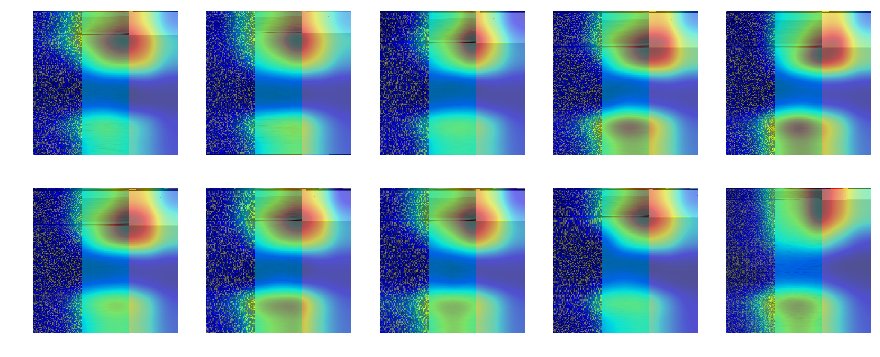

Family: alman
Image: ['efbfb89259d9da1d7d2dc2352609eeb9e91f87c27c5de2e7c0e82b535fc9b4f9.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 19.94
Image: ['5745f8c6537b05c822c2f8b9e5d94539291ffef4c564ea15bdc893c34a4630ab.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 15.83
Image: ['424154f34a9f95957520d8a445de351d55f00c602076877024c133c32d857d8b.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 18.49
Image: ['d11444716a3c4d2922178ea1bc8bd4767899094243e2ee37f4f7eafb2c8f4200.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 11.42
Image: ['7760a775e01e8ed965d01176ffdec8530f7b7b09a4fc2af0c087073f49bae557.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 18.96
Image: ['0d7cd2c9c8ddf4a8ccaa3cd76cb4c319e43f8bdf1e96fda22702b1cbfc600e91.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 14.13
Image: ['d3e69fde86c07c181c203eb73db7026d96ab0e86db6c92f648c559bdfa5d05d5.png'] - Class: ['alman'] - Pred: 1 (alman) - Prob: 16.30
Image: ['1d4ad30271feead0d706b282e4ead407479ceeedf8c70714c21a14488e13

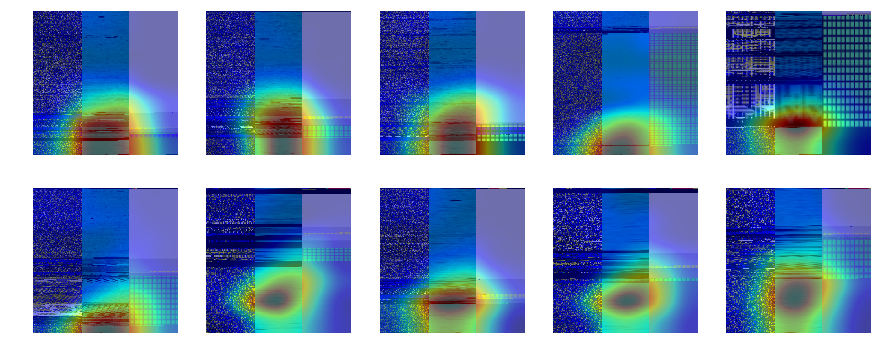

Family: autoit
Image: ['75277bdefdfe9b1a8dcb5de3fd3bb07ed38c9b9017502ebc75a3c1998c88eb64.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 12.41
Image: ['f07258bd5914be0ab28e4a81801e0edbafee215e7ce92602570f41878affdb34.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 18.47
Image: ['d7ea280cfa3a6398c09bf769932092e10e82b0aad580c02bc3769b7eeb8797d8.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 17.60
Image: ['ee037bcbbd7d6bcd7e96ea6ffcd6728c185e080db2ba0267e800819dc0b1bd82.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 14.07
Image: ['18667f8b148169e8feb72b988600da5e6358cad6110fb7e99dba6889a2f80439.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 15.78
Image: ['47e8d62660bf2a8c855025ca549f2980b4ce7e3e836f0dd06a05c30a2206132a.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 18.49
Image: ['94a7f85c1798cfeee611cf1430af76abaf047e2d33784c68022de5faea156ff6.png'] - Class: ['autoit'] - Pred: 2 (autoit) - Prob: 15.22
Image: ['0e7c02fc63fdcbe1b8bd36a166ccb6c25e6cc0b35c7f4

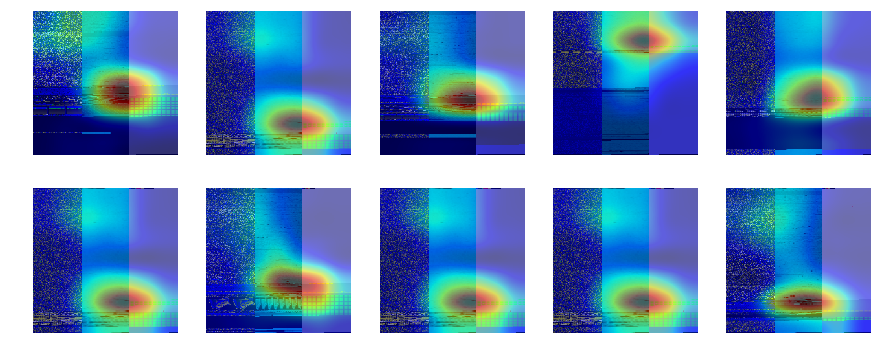

Family: daws
Image: ['caff333a8981e2237285bfb99be8533bd63eb5dce069dcc001a9589775fd32a7.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 23.91
Image: ['31368fade31ea507ebc96ab54a50c76d753d3d012a2eeae600492d92a40d028d.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 22.87
Image: ['d2680683b93f2d82dd85704012f641f421491952c2fef2195e7a02fa906fcb6b.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 21.23
Image: ['03adb66b163a1d89a928566f011e1f79efe4491216cfad05c7104f3e80cf3dc0.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 23.64
Image: ['1f1d96cedfbc911d3babbd97ea770a9604e305f75036357418018aabc508f417.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 22.42
Image: ['14a80307246ddc3cc46e3d08866db19a5c94571b982ae4abc371662f038089b7.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 22.31
Image: ['1aeda210c0c60086c7e10d313e3a6e4cd7efe0ebbb5d51559a0ce03e9c8ae066.png'] - Class: ['daws'] - Pred: 3 (daws) - Prob: 22.20
Image: ['a95f5f1445c55cc484387b7a63d0e1a3c891ece7ad7e41c91264b76e9252d7fe.png'] - Cl

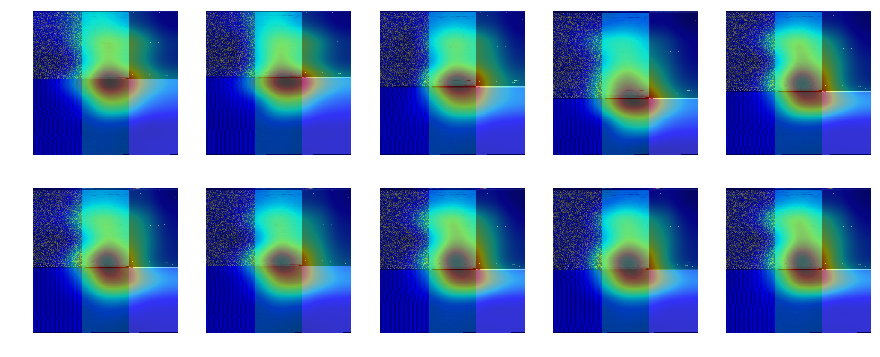

Family: delf
Image: ['85cd491954692bd0cba7d64bcc3ea7c67f94a4dc42b1f4847e7706048371bf1d.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 17.53
Image: ['a54848a6ec2ae98ec62bdd776a37b9a85b807657a1a13565bee09aa537242b0f.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 8.41
Image: ['73176bd77b9157654c94a3c1e1e617516ab86b746ca27ec1c694610c9f6f92ad.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 16.25
Image: ['5db04093bff7859a3dd0dab5f33018aff7a08db5914428c842526ed8d294bfef.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 19.14
Image: ['e7fbb9d212c76e1698d5bd8947f60700c2fe10a61eb9e8b6cf7716b4ac2fdacd.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 16.52
Image: ['0e519049cfb64fb837ed98242479e1adfead4da715dfdf83ddbbf18f582e36ec.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 10.34
Image: ['ce0e81de60fdc7f5a2fdc7698cbe2f3158b5c7557a6889e4f970c0d15cf51434.png'] - Class: ['delf'] - Pred: 4 (delf) - Prob: 17.75
Image: ['d06adcf933235b741f79c16ca09b124b2b27f193ea51721630b458374d7e67d1.png'] - Cla

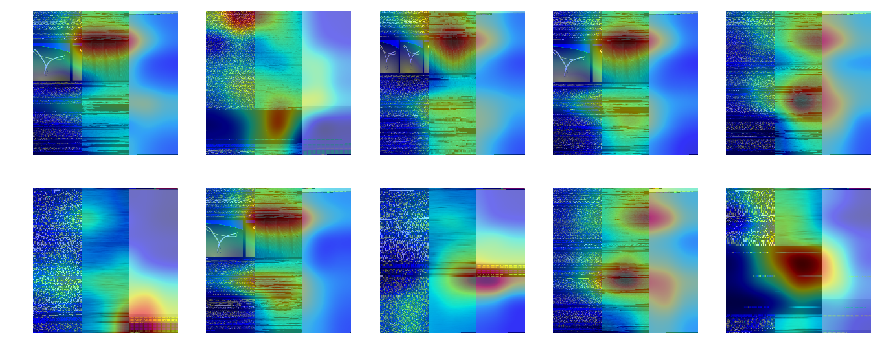

Family: gamarue
Image: ['61f27cad5d0f264988c3dbca52db8a4f8a4b9421c1d399c852cb32742f1ef477.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 15.06
Image: ['aa85241d736c1afacd96fdd96e9aa4c68715770abcbfa6a8f10e413eea4aa5c8.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 14.54
Image: ['95ef093a375b58f423d1a24ed30558b9b5795d297a495fc22ccfc9eec2bd01df.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 15.92
Image: ['6539259f76deec2418455dcd8a3517a7082ba4ab129a511666acd18a3db3ab18.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 14.54
Image: ['9b7b06febe80d17eb26ddca89fab82974684f05fbe6e1ef221dea457d568a804.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 14.54
Image: ['9106d2811b07041ae008166d20883520951d882c498beac2b72a724de15bc88e.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 15.92
Image: ['024d8beeb60c3181940ccc56f34410f09319ca440497f7ca11bd35cbc0f26e3c.png'] - Class: ['gamarue'] - Pred: 5 (gamarue) - Prob: 15.92
Image: ['d504215ab4f2e1977cb3e3fa08eb45

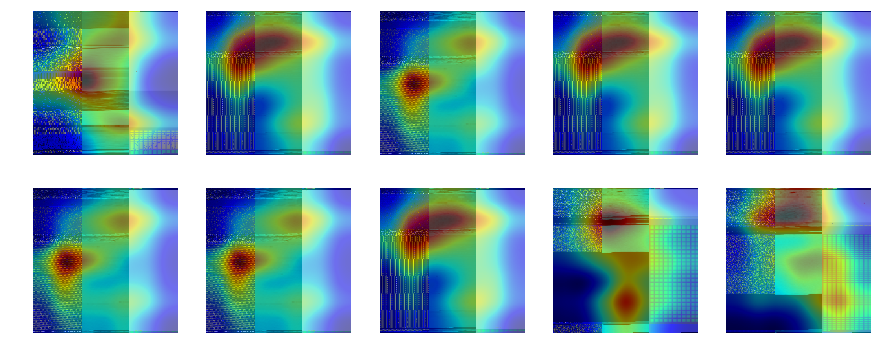

Family: ibryte
Image: ['0e63cc7ee47d7f97db0eb3f2b9380086cf750caf136587df302daae9fd1156d2.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 34.99
Image: ['5831bce03860df65ab424aa8a4e78248bab08a304eb6fb3fb56fadb16c1cc79a.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 30.91
Image: ['d162fa14760aac3af46971f854cdd9c8c2c02b2d35c1e23ce1c7a31cc17cb421.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 26.66
Image: ['90bd3945288ec8a076583c502d40311f761ee805baf8cb1fadb995f3a7d9d88e.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 27.20
Image: ['f9b24c9bd2970afc9b99180b7e64952e25bc3eab6b2102605d196acdece49da0.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 22.54
Image: ['2ddfa48155fbf3cb59dda8e6b93d2354258687fd8d8c7c1692e532c1665d866b.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 33.22
Image: ['1ed4e3a9c6cf85d41407dfda0275c15c0ba815679f4a859f3bdba863182390f2.png'] - Class: ['ibryte'] - Pred: 6 (ibryte) - Prob: 33.86
Image: ['2d7ebac90d39b684c328fb161e9c9a362f6bb29f077c9

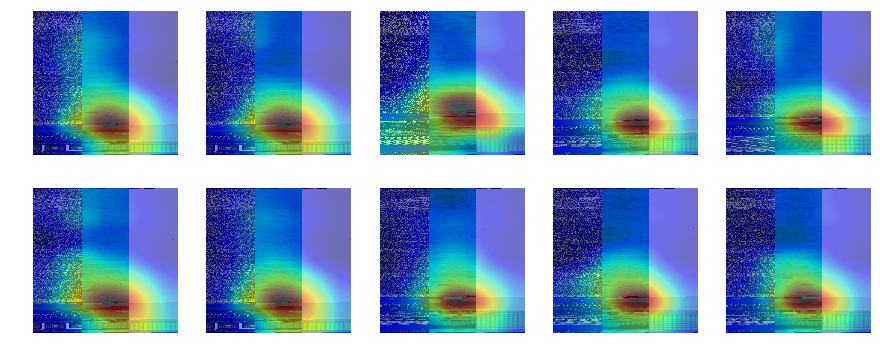

Family: loring
Image: ['695d1f10ffc75f4d796468bcfd8d045a676fde1651d73be60353470952e12393.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 18.57
Image: ['22c3afea6306d8fbea8cf1b50332dec133901fef03448ad52b469a74040f9e65.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 26.54
Image: ['aa390a5b73fef53ca509c0791da749ac3923b8828c0dd4cd10e5ba2a255b6120.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 19.66
Image: ['63a242418c9eee9ffef570398e0957bb74b6aa00e0a75493295aeb7f60861245.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 26.82
Image: ['7c1a0a19f924470ae58798fef6ea20da6e04241f65bc019b775d6e5e552c9086.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 27.63
Image: ['64e6468de0a02688e0bf912c3134f902948e5a128ac30c06f83bff3865ac8638.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 26.58
Image: ['f1d2829725d4132c94f44b5147c60be75ddc01f26899221068ea3f65d53de587.png'] - Class: ['loring'] - Pred: 7 (loring) - Prob: 24.36
Image: ['5ad18f10767ef9dc17fea47ec77c1b7666d477d0d4240

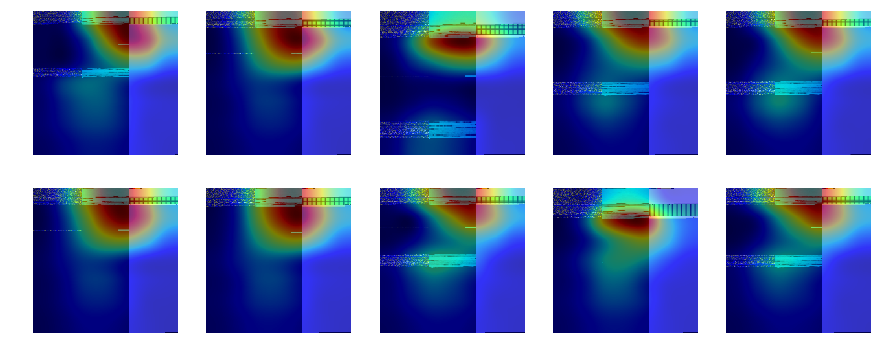

Family: mydoom
Image: ['a23c48484592582a7b049b792fc0f543c4734e825b1c0daa574c60f89422eca0.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 21.38
Image: ['ea9529e05f7c6d55f0c3b9bcc11c5738b7235520525ecbdec3d1c6deb6e8a036.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 13.69
Image: ['9793a36f283c965261cd1029491b3b4da55fbfb1e864b10a6df163670fc95a9c.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 21.54
Image: ['1f51d943f4eacd981b41a029152986f85272eae01fd07b3dbc33598aaa466970.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 19.46
Image: ['0326334e24582c07795fcea9e636c57057d3e2572cf05f98549113066dbcc008.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 19.23
Image: ['81437f70ff1ffd2fe29718419c8bafb03862802f501ffa8b1dbbef89c3e9e44c.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 18.53
Image: ['d7a90fc3e48e40a1eda52348c7030acdec96dd0ba48463666561d5cecbedddd3.png'] - Class: ['mydoom'] - Pred: 8 (mydoom) - Prob: 20.23
Image: ['00a84282c9135d5622835a6768fcd4e48eb2ee9f6cc4b

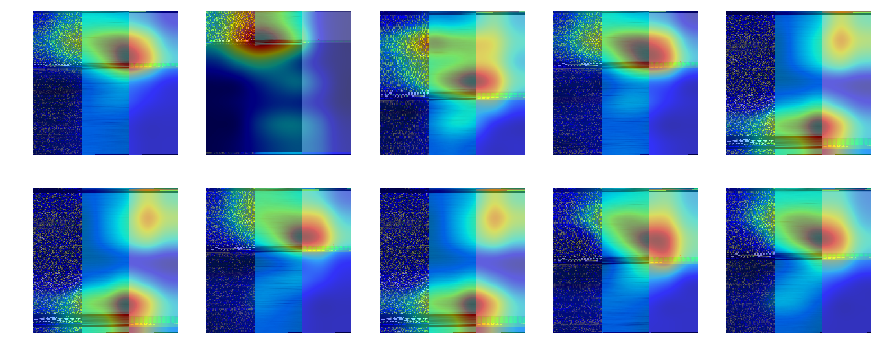

Family: qukart
Image: ['7ee1043b5647c49dd948e05d43c3a782d299a9ceb4c234ac2a9010e31700880e.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 30.05
Image: ['ce71adef01a3b361ece846d16ff3b5d47ac820f8e24369bd386d4e30a7435755.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 28.29
Image: ['991da893f5ac1205b9044e6332c9dddbe772eef03a92dbeb4aea91015a33e651.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 15.29
Image: ['36d1b7618ae3a2699537bfc7c7001f66f6de69ca5601443327ada299a89b1b4c.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 20.89
Image: ['a3c039669ecbf60015b0a67042dfeef794d55bb9cd0e0831b393034128c4be9c.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 32.85
Image: ['ad9c9f9c56b860d54fcfc64016ddf0246f2e9b7db331f3ad5ea96c8e7c7284cb.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 28.82
Image: ['b4f5c528b98202bae8563ef826fb11a81299283539680c5d57381806588e4d7b.png'] - Class: ['qukart'] - Pred: 9 (qukart) - Prob: 28.64
Image: ['c3ded383a7f38b1848f2824554f019134da667991602a

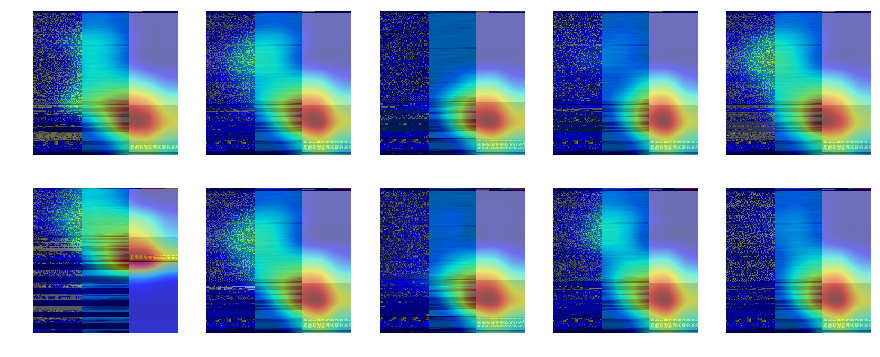

Family: ramnit
Image: ['566e3dd026509092a6bf0b04179b87a855b36a9f1e8fa73f4aa595f9ca259927.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 15.78
Image: ['61a042d1c9abde067c8d864c6a9bd390e79aed3b3b4127b845f805919611e608.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 17.55
Image: ['35cbbbccf01079c514dced20e7620e4721320dc9de7aab62df73979ea651a381.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 20.21
Image: ['29a12ce7028f195004909eb3ef79c9dd22654da17f50bcd582719f52fb743d96.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 14.05
Image: ['159eb0eb101ed818a15bda722a1f9ec1b1da3227e046973f8561553a196a4f22.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 17.16
Image: ['900997ac4d4c1c42d8968db42cb5513306594ff44121bd23a09c084252f07740.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 13.64
Image: ['6393ba4b0452609d1aa609207eed2b121dc61a715e982e3e14119a343bac0cf3.png'] - Class: ['ramnit'] - Pred: 10 (ramnit) - Prob: 19.34
Image: ['afeb20cfb981ed42c966a08a4328c9523171b8

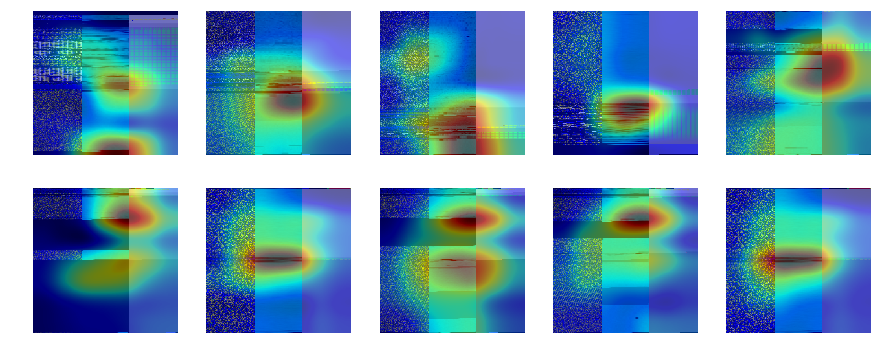

Family: sality
Image: ['86ab3f0ccf30686f8ef7c1eacb3d76b8edcf89c044ff92ad9e74f3067798f607.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 23.85
Image: ['d0eb285a4f613c2ae38627348806d5d2c1e02936479f77bd462979a7760a9f25.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 22.99
Image: ['0fd8d72a13578b196930780c154876878264dada891d44516b4e0a5f02105b8c.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 19.62
Image: ['51e9e9d8fba57179e98e2b33a71529f74fa89bac1c052ef1499aa0795595fc28.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 15.91
Image: ['2407e2b4695b525b0009b1bf5113ee1d3564ff047c619baa2043bd846599dfe0.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 16.15
Image: ['e255701ebf0d6ee473e78dd6ecbe4d6e36405f5db7e76a45c8bf29a8e04ec481.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 36.56
Image: ['2c701a5cbc54d736afaf0236562e64093cb6e30d5c431aad7c16391fbe375538.png'] - Class: ['sality'] - Pred: 11 (sality) - Prob: 22.76
Image: ['cedb690f013c64b33dadcd8fc5e3b5ff6d8b6a

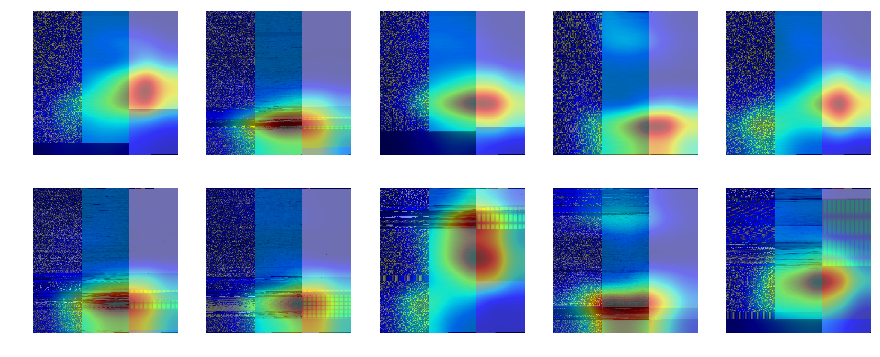

Family: simbot
Image: ['3c9b831095decde0a533e23f00e836d57d7fd17e10687a31e04d8271b5a6c580.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 29.03
Image: ['41d1926e4d6e3d36f3534bef6b57f0d103c4ef7ed72dab19069fe9550ae0f91b.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 29.34
Image: ['659de7a9191bac18f8077c131ac50cdfca85e080ff8ff48eaaa48b96744e11d2.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 31.03
Image: ['5661bf52aaef5ba248dd3ca0f768a1e97283180ff497216846a43dc9a70157ef.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 30.04
Image: ['1eb33bf41b271e580983c1a45073235cb1d3136ee00cd55673a258e1f8b9c888.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 18.36
Image: ['3194a0c214ef21ba85f75cb4e7261d64a54865f789ef6a8acac7daf8902d0b36.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 30.72
Image: ['f7575b25e1c484e56a9900a41eb2ee5a176d1391a744b9054537cc0e2d86bd5a.png'] - Class: ['simbot'] - Pred: 12 (simbot) - Prob: 30.55
Image: ['33db9e9dcc26bcc1f1c4548bc7777a36d7b9a8

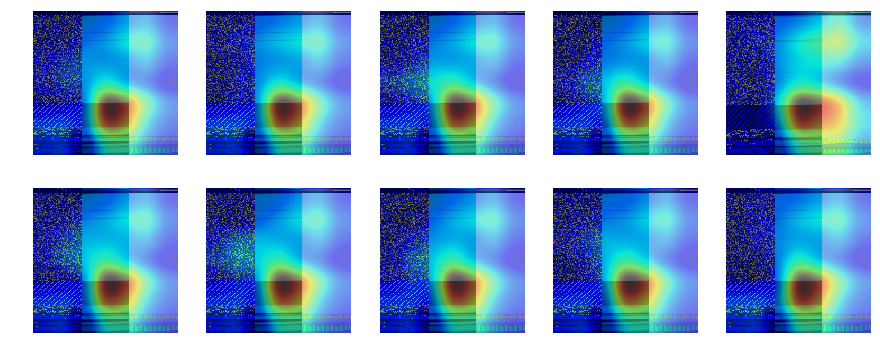

Family: softpulse
Image: ['c206adde76b3146d94767953db35eec304903091de2f7b7a236d4ce60e394384.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 32.33
Image: ['59dcef1deb675d35aa026e02b97cfb9c8ee06fd1340a082ae6f8f44012ccb70f.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 32.33
Image: ['a972cb5c61edb1b84666757e33c006b87367ae908aa75505ec37494dfe7dbdcf.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 29.73
Image: ['b3048dfc4513563faeea6c365c97c52ffd82d6adf9ff524988abdb1784581344.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 29.57
Image: ['03f94091a85997476ebadb99e8cf6b9f8c8312ef2679bba5510823f120ca0b61.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 32.32
Image: ['cc7b12c065e7270296ecc88855611a144d053381327d9e969de1c0fb6dd6e685.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 29.75
Image: ['56dfef312b9d33ec2b893679610f53937644fd6a76b98a6f839d0e3a9df51c77.png'] - Class: ['softpulse'] - Pred: 13 (softpulse) - Prob: 32.32
Im

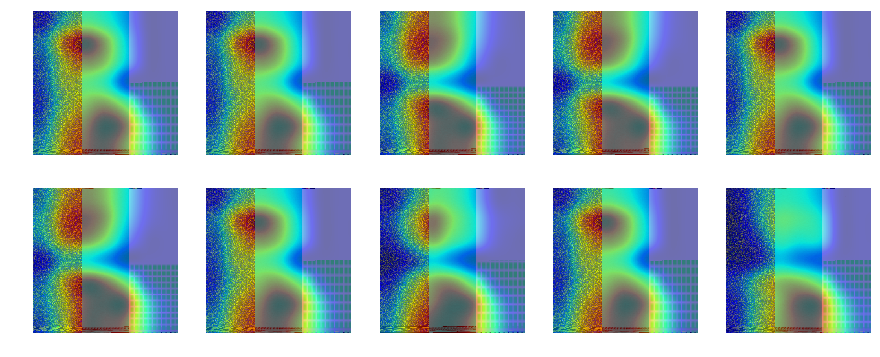

Family: viking
Image: ['09213b632e799f6d5d50bdf88166e8fe3b7d024419ff8ade380086a18dae1298.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 19.48
Image: ['5696afaf52a86a4b5242890f3a1a103dcec8244f77359683b8b6765670b1bfab.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 20.90
Image: ['1521c993a31cda1db824a22e2a8cf7a81015c234c5572c30fcad18ed9705d734.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 26.80
Image: ['ca171ea373961fe9ff4c728d5e86ff271b34f427b77cbe0179f97a8e7d40801c.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 21.89
Image: ['5c2c568bf3623cc2720117d1d87c41fc6e2318268fcff4ce8505faae6eec8841.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 21.79
Image: ['5b18a00599197fd157fe4c3068bc07a65a33c083d2839ac6b4f6a0b8ac23cef1.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 22.71
Image: ['4e62fa3ea4491e781aa76121203e620295531793680a888024c3290487ace9c3.png'] - Class: ['viking'] - Pred: 14 (viking) - Prob: 20.59
Image: ['812117ae17cc31b5e5b6221ae3086ffb396a9d

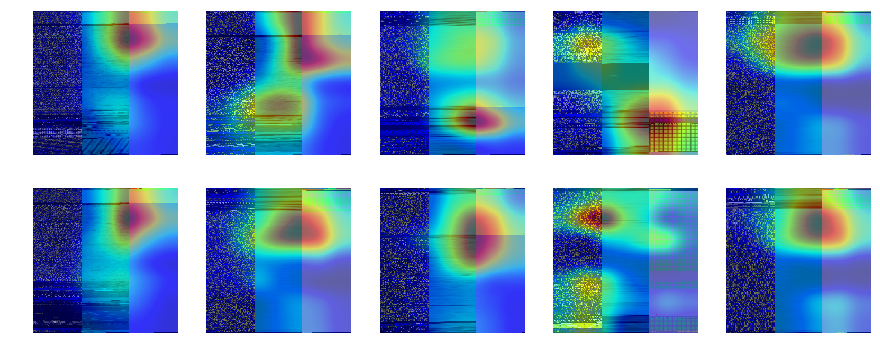

Family: virlock
Image: ['0289527165d3f2c0de1fb51784d1b89f04b442b0a61769957026f60d55506745.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 28.64
Image: ['a3dcbb52062f144be6a8d51c2169a7dfc2a1530b4da97786360ee8dfc1c0d319.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 18.75
Image: ['821e4b6b3d80ab530533b3f6b9d90bca668a858406f3892869df3f359239411b.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 17.91
Image: ['2b3238134d5141bb6455b00b6b4e8c35122dd9e6812701a402a462ec0c28ed52.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 21.30
Image: ['186b9161564a12a4b11c94f03aced4acd669b758c06f1403081c3535dc9309af.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 26.48
Image: ['58d95ad04d101697024e9240c96d0c5bea6fdb31cc6ca6c7cd2b38c71ec234c0.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 22.10
Image: ['818cf4075b96ae70feb0a3b955117763654de53bbb84f4e034b5e0a430813e01.png'] - Class: ['virlock'] - Pred: 15 (virlock) - Prob: 19.67
Image: ['1b07901d3f55c771db6aa5f

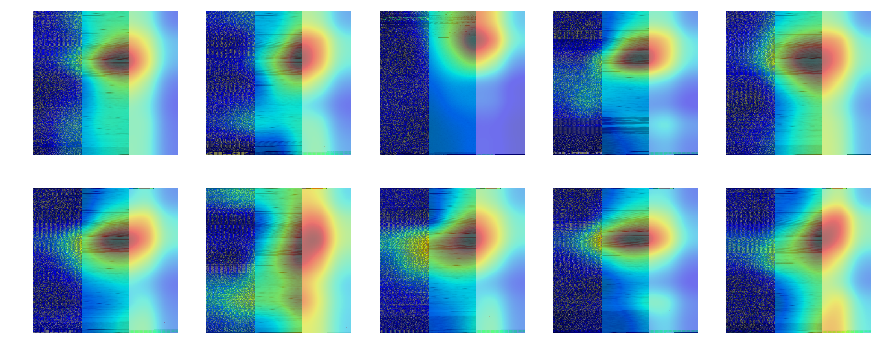

Family: vobfus
Image: ['6bc130ffec8e504c39d22aebf431f3a2b8482ca31236f21862cfa0b7a7417f6a.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 17.51
Image: ['6c3cf1e8dcc68c949e6e139a13db456b935d1469bed972eca70f8ded15ad30bd.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 22.06
Image: ['befc37c1b506be75fc098cd6e30629f92854e467f6f1e0fe2dc06fade3bda90d.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 14.96
Image: ['375c20a364c8ea1cdc13285311f3e3d4b4f10fa80891b99b778802776e2707ef.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 22.06
Image: ['4c75fdd6e8902d75947e30505332d7ca377d54b9716b35c26e07f5d066a1ab83.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 14.60
Image: ['e0304fd35a21e5b8d068057f75f2830834b0a107bb1491ad4280f410e27a1822.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 17.70
Image: ['1a10554f09010abd226f9c4f32bd7dff9e784a689e4ea9e83d43cfc4e4bb0a7d.png'] - Class: ['vobfus'] - Pred: 16 (vobfus) - Prob: 22.06
Image: ['8c27a75ae17db5b9df0e6080bf9b4b38759a53

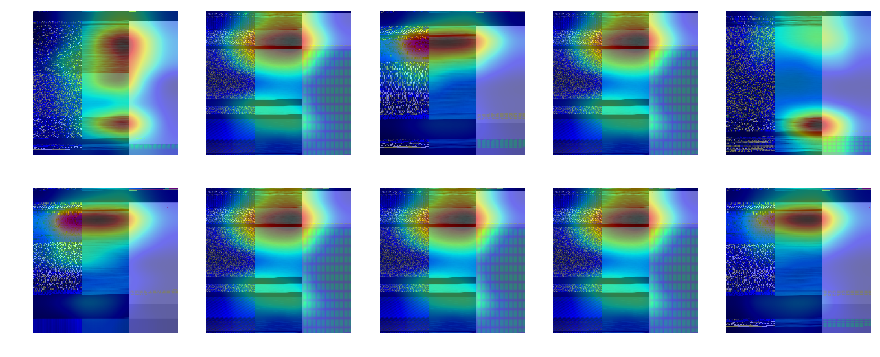

Family: wapomi
Image: ['db603b319c3d4a03aa5f95a8dd7aafa8781dacf876d95ca7f3afb702829bd47f.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 29.24
Image: ['9b387030f6bfedd1d1b433c3c234ab2e530a6e6457178bf831f36d980a6cd729.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 14.44
Image: ['fc1a099796049824b0a480730acc42979989c40e547b9b406469418f142384e1.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 21.55
Image: ['85375e60c53cc9958253e15966b2ea9dc18544b0874ef98d9c8ffdc49f63e91b.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 15.23
Image: ['4518c22350e1cc01c8ba72d45d9b859ae95d4be4341b411e5641ac9fd5b66686.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 24.99
Image: ['9a6c36e9aba2f04422cb78d076c9a58b1cdeddb86638da23ef5c9a4d5f7897ff.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 24.97
Image: ['1fd6f8ba6c688e8261cf6c65c290bb92b091159c7e46710622802f672ed8fcff.png'] - Class: ['wapomi'] - Pred: 17 (wapomi) - Prob: 24.12
Image: ['542239b327858960bb226c126d379b3f40da95

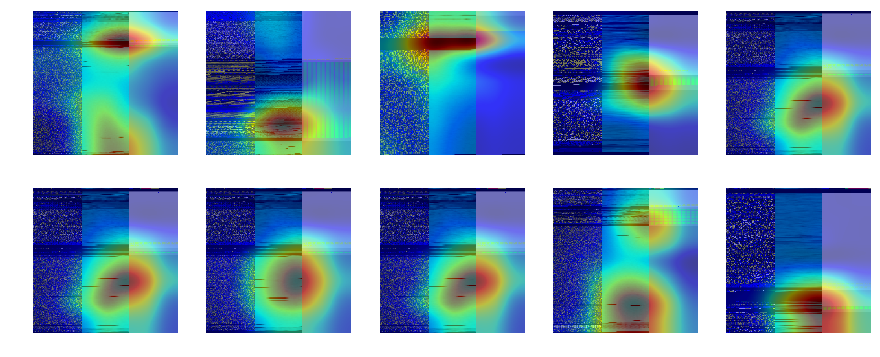

Family: zbot
Image: ['8dca2175b9343a9278ffd8051879caf3c4845b495ed2f4f96710db66b1f02f90.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 12.82
Image: ['5e5677d93894fd830ae82f29fe6618127c1e32549447955a25ed828e5f55106f.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 11.79
Image: ['e071a2e59df04e1eaac66b1ac90c5fbb348af90eb5f1cfcae7cee20895ab4811.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 11.82
Image: ['a95d44da962fb6c741d3a2ac616c8747125322f7b7893165fe79355fb6eed268.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 13.12
Image: ['6a1a6eb99fe9a394c538f70d7f9652dbb4732054570903121121e0d1fa0a96c5.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 16.99
Image: ['f05a7869ade9502f357ca34a064aae5df9bd5760c85d0fa155e67956224539a0.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 17.56
Image: ['2daa0fa1792be240398b737671d2d4f3226b582a3d3e4e7c4274375924dfb3e6.png'] - Class: ['zbot'] - Pred: 18 (zbot) - Prob: 11.18
Image: ['3495ab887fb9f377bfd69b1e4b48294f9d6ab96c74c5d5b98626099bc3c9d25b.png

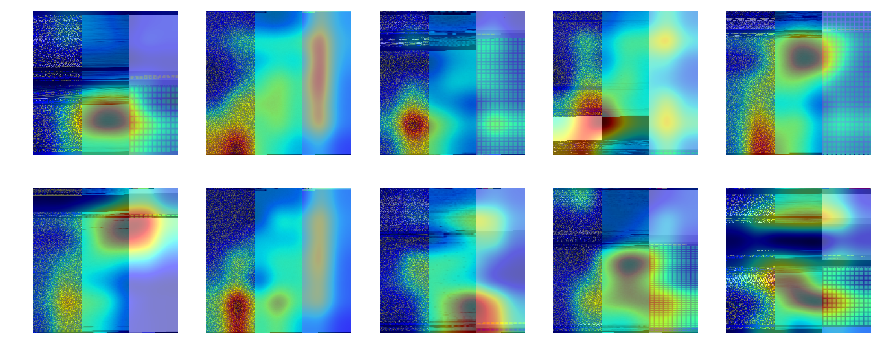

Family: zegost
Image: ['1c1e16ff949d0ebbac4194fc19be61d4e03d9dd3d1f88459c9808c579f588fa4.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 23.43
Image: ['0068b9988fa6e405d50cf31668dc172b34fd4839d0cf1703b1c22a6dc293f3d3.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 21.51
Image: ['e800221e1183de7db463488d56401cb1db1ad2621ff789699e6f4f0d06a80788.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 22.46
Image: ['9fcae5c258401d188d6228ac54218a7a6497f2b126d53778ede16bed95979f21.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 18.13
Image: ['e48fd3ff8aab1dbb8bf56823527eed6a3cd70490e1cd56557a19e6b7d489b6c1.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 24.10
Image: ['150377b4bf9f0a299dd27ca8a488fc78fe742ea31e5403c634390aabd2eba608.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 22.56
Image: ['7fdd29e1cfb0d49ded5ea3c96cf5749ced274affdd8cd8069fec4deef77acbef.png'] - Class: ['zegost'] - Pred: 19 (zegost) - Prob: 22.67
Image: ['9a5358680440d6dc403d15e07aa53f5b2e4f5d

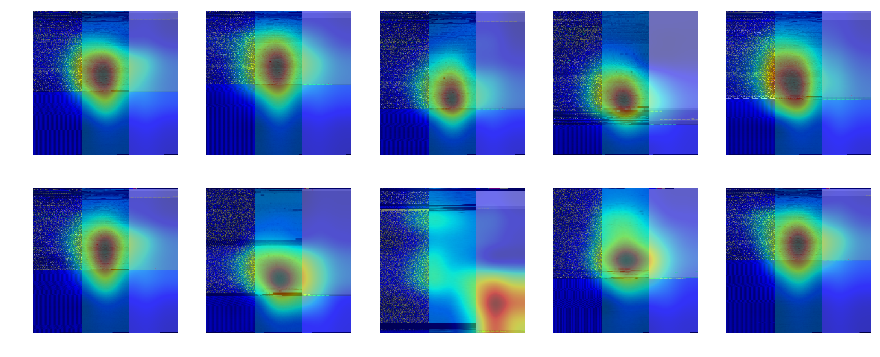

In [8]:
samplesbyfamily = 10
samplesbyrow = 5
for fam in list_fams:
    print("Family: %s" %(fam))
    fam_samples = [name for name in list_paths if fam in name]
    image_paths = random.sample(fam_samples, samplesbyfamily)
    
    #fig = plt.figure(figsize=(16, 8))
    f, ax = plt.subplots(samplesbyfamily//samplesbyrow, samplesbyrow)
    f.set_size_inches(3*samplesbyrow, 3*(samplesbyfamily//samplesbyrow))
    ind = 0
    
    for path in image_paths:        
        img = io.imread(path)
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        img = image.img_to_array(img)
        
        x = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(x)
        x = preprocess_input(x)
        pred_class = np.argmax(model.predict(np.array([x])))
        pred_proba = np.amax(model.predict(np.array([x])))
        print("Image: %s - Class: %s - Pred: %d (%s) - Prob: %.2f" %(path.split('/')[-1:],path.split('/')[-2:-1],pred_class,list_fams[pred_class],pred_proba))
        
        heatmapguided = visualize_cam(model, layer_idx, filter_indices=[pred_class], seed_input=x, penultimate_layer_idx=penultimate_layer_idx)        
        
        ax[ind//samplesbyrow,ind%samplesbyrow].axis('off')
        ax[ind//samplesbyrow,ind%samplesbyrow].imshow(overlay(heatmapguided, img))
        ind = ind + 1
        
    plt.show()